[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Accessing and assessing CMIP6 climate projections

This Notebook provides a practical introduction on how to access and extract information from the CMIP6 climate projections data available in the Pan-European Climate Database version 4.2 ([PECDv4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview)) dataset of the Climate Data Store (CDS).

The workflow shows:
* how to quickly download spatially aggregated temperature data for the 6 CMIP6 models provided in the PECDv4.2 under one of the four available emission scenarios
* how to subsample a particular country from the downloaded data
* how to concatenate this information with that coming from the historical reanalysis available in PECDv4.2
* how to calculate monthly/annual averages
* how to visualize the ensemble of models to extract useful information
* how to derive estimates about climate change projected trends

For illustration purposes, this notebook uses a short temporal subsample of the PECDv4.2 dataset. Likewise, only a subset of the available CMIP6 climate projection models and emission scenarios is downloaded and analyzed. This approach is intended to demonstrate the workflow and methodology rather than to produce robust, policy-relevant impact assessments.
It is important to emphasize that for rigorous climate impact studies, the use of such limited data is not sufficient. Reliable analyses should be based on longer time series (typically at least 30 years) to capture interannual climate variability and trends, as well as on multiple climate models and scenarios to quantify uncertainty and assess model spread.

>**Note**:  
> For the sake of simplicity, this tutorial will make use only of spatially aggregated data (NUTS 0 aggregation, find more about NUTS on [Eurostat](https://ec.europa.eu/eurostat/web/nuts)), for only one country and one climate indicator (TA), averaged annually and for a limeted number of years. Interested users can expand the range of years considered, use different climate/energy indicators, or even use gridded data considering a single grid point (with minor modifications to the code).

## Learning objectives 🧠

1. Learn how to quickly download all the needed projections (and historical) data from the CDS
2. Learn how to compute simple operations with the obtained dataframe
3. Learn how to plot the timeserie of an ensemble of climate projections
4. Learn how to compare climate projections to the present/recent past

## Target audience 🎯

Anyone interested in accessing, visualising, and extracting basic information from climate projections data.

## Prepare your environment

### Import required packages

This script begins by importing several Python libraries that are essential for data handling, file management, and visualization: [glob](https://docs.python.org/3/library/glob.html), useful for searching files in a directory using wildcard patterns; [os](https://docs.python.org/3/library/os.html), which includes functions to interact with the operating system, especially for file and directory operations; [pandas](https://pandas.pydata.org/), a powerful library for data manipulation and analysis, here used to read/write CSV files, clean data, and performing statistical analysis; [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html), widely used plotting library for creating static visualizations in Python such as line plots, scatter plots, bar charts, and more — ideal for visualizing time series or statistical trends; [numpy](https://numpy.org/doc/stable/): a foundational library for numerical computing in Python often used in tandem with Pandas for numerical calculations like standard deviation, averages, etc.; [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file): a Python library that provides programmatic access to the Copernicus Climate Data Store (CDS), allowing the download of relevant data for this work; [Pool](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool) from [multiprocessing](https://docs.python.org/3/library/multiprocessing.html), which enables the use of multiple processors on your machine and is used here to handle parallel API requests.

Together, these imports set up the core environment for reading multiple files, manipulating datasets, computing statistical summaries, and producing visual plots: all essential steps in a typical data science or climate analysis workflow.

In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cdsapi
from multiprocessing import Pool

### Set up the CDS API and your credentials

This step is essential to be able to download the data.This step is essential to be able to download the data. For a complete walkthrough of downloading data from the Climate Data Store (CDS) via the CDS API, see the notebook [*Downloading PECDv4.2 data from the CDS via cdsapi*](./download-data-from-cds.ipynb).

If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.

Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes ```"your_api_key"```). Your token can be found on the [CDS portal](https://cds.climate.copernicus.eu/profile) (you will need to log in to see your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [2]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

In this example we retrieve the "2m temperature" (i.e. 2-metre air-temperature) variable at "NUTS 0" spatial resolution from the PECD version "PECD4.2". Two temporal streams are combined:
- Historical data derived from the "ERA5 reanalysis", covering time period 1991-2020 (most recently adopted standard for climatological normals, suggested by [WMO](https://wmo.int/)).
- Future projections from six CMIP6 models ("AWI-CM-1-1-MR", "BCC-CSM2-MR", "CMCC-CM2-SR5", "EC-Earth3", "MPI-ESM1-2-HR" and "MRI-ESM2-0"). 
For each model we request the period 2015-2044 under the emission scenario "SSP2-4.5".

Given the large amount of data required in this exercise, it won't be enough to just copy the API request in a cell and run the retrieve of data: following the example of Notebook [*Downloading PECDv4.2 data from the CDS via cdsapi*](./download-data-from-cds.ipynb), we will instead split the large request into smaller ones and run these requests separately with multiple processes and the use of a dedicated function.

### Set up the parameters for data download

This section of the code defines several variables and paths that will be used for the data download. Some of these variables will act as parameters for the API requests that will be made later inside a function. While defining these, we will also create two lists of years, one for historical data and one for projection data, composed of pairs of years, to split an otherwise too large request to be made all at once.

In [3]:
# creating/specifying folders for download
download_dir = "cds_data/climate_change_impacts/"
os.system(f"mkdir -p {download_dir}")

# download variables
dataset = "sis-energy-pecd"
pecd_version = "pecd4_2"
origins = {
    "historical": ["era5_reanalysis"],
    "future_projections": ["awi_cm_1_1_mr", "bcc_csm2_mr", "cmcc_cm2_sr5",
                           "ec_earth3", "mpi_esm1_2_hr", "mri_esm2_0"],
}
emissions = ["ssp2_4_5"]
vars = ["2m_temperature"]
spatial_resolution = ["nuts_0"]  # NUTS 0 stands for country-level

# splitting time windows into smaller chunks to ease download procedure
start_year_h, end_year_h = 1991, 2020  # start and end year of historical time series
start_year_p, end_year_p = 2015, 2044  # start and end year of projections time series

hist_years = [str(i) for i in range(start_year_h, end_year_h + 1)]
proj_years = [str(i) for i in range(start_year_p, end_year_p + 1)]
n = 2
hist_years_list = [hist_years[n * i: n * (i + 1)] for i in range(0, len(hist_years) // n)]
proj_years_list = [proj_years[n * i: n * (i + 1)] for i in range(0, len(proj_years) // n)]
print(f"hist_years_list: {hist_years_list}")
print(f"proj_years_list: {proj_years_list}")

hist_years_list: [['1991', '1992'], ['1993', '1994'], ['1995', '1996'], ['1997', '1998'], ['1999', '2000'], ['2001', '2002'], ['2003', '2004'], ['2005', '2006'], ['2007', '2008'], ['2009', '2010'], ['2011', '2012'], ['2013', '2014'], ['2015', '2016'], ['2017', '2018'], ['2019', '2020']]
proj_years_list: [['2015', '2016'], ['2017', '2018'], ['2019', '2020'], ['2021', '2022'], ['2023', '2024'], ['2025', '2026'], ['2027', '2028'], ['2029', '2030'], ['2031', '2032'], ['2033', '2034'], ['2035', '2036'], ['2037', '2038'], ['2039', '2040'], ['2041', '2042'], ['2043', '2044']]


### Create a function to handle the data download

We will now build a function to send a single api request; later we will call it using the multiprocessing library.

In [4]:
def retrieve_cds_data(
    dataset: str,
    pecd_version: str,
    temporal_period: list[str],
    origin: list[str],
    variable: list[str],
    spatial_resolution: list[str],
    year: list[int],
    emissions: list[str] = None,
):

    # dictionary of the api request
    request = {
        "pecd_version": pecd_version,
        "temporal_period": temporal_period,
        "origin": origin,
        "variable": variable,
        "spatial_resolution": spatial_resolution,
        "year": year,
    }

    # build the file path to the downloaded data
    file_path = (
        f"{download_dir}/"
        f"{pecd_version}_{temporal_period[0]}_{origin[0]}_{variable[0]}_"
        f"{spatial_resolution[0]}_{year[0]}"
    )

    # add emissions field if needed
    if emissions is not None:
        request["emission_scenario"] = emissions
        file_path += f"_{emissions[0]}"

    file_path += ".zip"

    # initialize Client object
    client = cdsapi.Client(cdsapi_url, cdsapi_key)
    # call retrieve method that downloads the data
    client.retrieve(dataset, request, file_path)

### Generate a list of API requests, launch the download and unzip files

This section of the code focuses on creating a list of requests that will be used to download data from the Copernicus Climate Change Service (C3S) Climate Data Store (CDS). Each item in this list represents a specific data download request.

In [ ]:
requests = []
# outer loop through variables
for var in vars:
    period = "historical"
    # loop through historical years
    for year in hist_years_list:
        request = (
            dataset,
            pecd_version,
            [period],
            origins[period],
            [var],
            spatial_resolution,
            year,
        )
        requests.append(request)
    period = "future_projections"
    # loop through projection years
    for year in proj_years_list:
        request = (
            dataset,
            pecd_version,
            [period],
            origins[period],
            [var],
            spatial_resolution,
            year,
            emissions,
        )
        requests.append(request)

# print requests (one every 5)
print(f"total requests: {len(requests)}")
for request in requests[::5]:
    print(request)

total requests: 30
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['2m_temperature'], ['nuts_0'], ['1991', '1992'])
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['2m_temperature'], ['nuts_0'], ['2001', '2002'])
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['2m_temperature'], ['nuts_0'], ['2011', '2012'])
('sis-energy-pecd', 'pecd4_2', ['future_projections'], ['awi_cm_1_1_mr', 'bcc_csm2_mr', 'cmcc_cm2_sr5', 'ec_earth3', 'mpi_esm1_2_hr', 'mri_esm2_0'], ['2m_temperature'], ['nuts_0'], ['2015', '2016'], ['ssp2_4_5'])
('sis-energy-pecd', 'pecd4_2', ['future_projections'], ['awi_cm_1_1_mr', 'bcc_csm2_mr', 'cmcc_cm2_sr5', 'ec_earth3', 'mpi_esm1_2_hr', 'mri_esm2_0'], ['2m_temperature'], ['nuts_0'], ['2025', '2026'], ['ssp2_4_5'])
('sis-energy-pecd', 'pecd4_2', ['future_projections'], ['awi_cm_1_1_mr', 'bcc_csm2_mr', 'cmcc_cm2_sr5', 'ec_earth3', 'mpi_esm1_2_hr', 'mri_esm2_0'], ['2m_temperature'], ['nuts_0'], ['2035', '2036'], ['

These requests can be parallelized with multiprocessing.

Afetr that, we unzip the downloaded data to be ready to use our CSV files.

In [ ]:
# parallel downloads
with Pool(8) as p:
    p.starmap(retrieve_cds_data, requests)

# Unzipping every file in our folder
for fname in os.listdir(download_dir):
    if fname.endswith(".zip"):
        os.system(f"unzip {download_dir}/{fname} -d {download_dir}")

## Put data together keeping only necessary information

Now that all the needed data is downloaded and unzipped, we can load them, select the countries we are interested in, and put together different datasets under the same table (DataFrame), which can be saved as CSV. Eventually, we might decide that, for the purposes of a study, hourly information are excessively detailed: resampling them (e.g. to monthly temporal resolution) might then save us some space and time for future computations. Optionally, one could also decide to get rid of the original downloaded files: they may be unnecessarily occupying a lot of space.

In [7]:
# Checking the size of the folder where our downloaded CSVs are stored
print(f"Checking size of download folder: {download_dir}")
dirsize_bytes = sum(
    os.path.getsize(os.path.join(dp, f)) for dp, _, files in os.walk(download_dir) for f in files)
print(f"Total size: {dirsize_bytes / (1024 ** 2): .2f} MB")

Checking size of download folder: cds_data/climate_change_impacts/
Total size:  2326.62 MB



We start by defining several variables and paths that will be used throughout the following steps.
Additionally, since we want to focus the analysis on Italy, we will define a list of ISO CODES containing only 'IT' (Italy). You can change the latter or add more codes to the list to target other countries; we will use it after the download to keep only those countries' data.

In [8]:
# creating/specifying folders for: results, ancillary data
results_dir = "results/climate_change_impacts"
os.system(f"mkdir -p {results_dir}")

# path to shape file of NUTs 0 (country-level) regions
nut0_fpath = "shape_files/custom_spatial_aggregation/NUT0_ADM0_PECDCODE.shp"

# defining datasets and time intervals of interest
stream_list = ["H", "P"]  # stream codes (H: historical, P: projections)
p_models = ["AWCM", "BCCS", "CMR5", "ECE3", "MEHR", "MRM2"]  # proj models
p_scenarios = ["SP245"]  # proj scenario(s)

var_code = "TA"  # TA, K
units = "°C"  # Degrees Celsius

# defining countries of interest (iso codes)
country_list = ["IT"]  # you can add more elements, e.g "FR", "DE", ...

Now we will construct the DataFrame relative to the data that we will later analyse. 

To do so, we exploit a for loop that runs through the streams, models, and scenarios: each single dataset will be added to a big DataFrame that in the end will contain all the data we need. We will also resample the data to a monthly resolution taking the hourly mean in each month.

>**Note**  
>  For a detailed walkthrough of this DataFrame construction process, see the Notebook [*Accessing, organizing, and visualizing CSV data*](./explore-csv-data.ipynb).

>**Note**  
> Although we choose to use Pandas here, the same data loading and manipulation can also be done with xarray.

In [9]:
# Initializing the DataFrame that will contain all the data
df = pd.DataFrame()

# Loop over streams
for stream in stream_list:

    # Defining years, models, scenarios
    if stream == "H":
        start_year = start_year_h
        end_year = end_year_h
        models = ["ERA5"]  # we can use 'ERA5' to specify the model for H
        scenarios = ["NA---"]  # we don't have scenarios for the ERA5 reanalysis
    else:
        start_year = start_year_p
        end_year = end_year_p
        models = p_models  # here we want to consider the models previously listed
        scenarios = p_scenarios  # same with the projections scenarios (SSPs)

    # Loop over models
    for model in models:

        # Loop over scenarios
        for scenario in scenarios:

            # 1) obtain list of files
            if stream == "H":
                glob_p = f"{stream}_{model}*{var_code}*{scenario}*.csv"
            else:
                glob_p = f"{stream}*{model}_{var_code}*{scenario}*.csv"
            all_files = sorted(glob.glob(os.path.join(download_dir, glob_p)))
            # print(glob_p)

            # 2) select needed years
            needed_files = []
            for year in range(start_year, end_year + 1):
                files_y = [file for file in all_files if f"S{str(year)}" in file]
                needed_files += files_y
            # print(f"Importing following files for stream {stream}: ", needed_files)

            # 3b) load and combine needed files
            df_list = [
                pd.read_csv(file, comment="#", index_col=["Date"], parse_dates=["Date"])
                for file in needed_files
            ]
            combined_df = pd.concat(df_list)

            # 4) Select country(ies) of interest
            for cty in country_list:
                if cty not in combined_df.columns:
                    raise ValueError(f"Country {cty} not in dataset")
            combined_df = combined_df[country_list]

            # 5) Add stream info to column names
            if stream == "H":
                combined_df.columns = [f"{stream}_{col}" for col in combined_df.columns]
            elif stream == "P":
                combined_df.columns = [
                    f"{stream}_{model}_{scenario}_{col}" for col in combined_df.columns
                ]

            # 6) Add to final dataframe
            df = pd.concat([df, combined_df], axis=1)

# Resampling data
df = df.resample("MS").mean()  # 'MS' stands for Monthly & Start (to show start date of the month)

print("Final dataframe:")
print(df.head())
csv_fname = "complete_df.csv"
df.to_csv(os.path.join(results_dir, csv_fname))

Final dataframe:
                 H_IT  P_AWCM_SP245_IT  P_BCCS_SP245_IT  P_CMR5_SP245_IT  \
Date                                                                       
1991-01-01   3.706829              NaN              NaN              NaN   
1991-02-01   3.099953              NaN              NaN              NaN   
1991-03-01   9.519538              NaN              NaN              NaN   
1991-04-01   8.980866              NaN              NaN              NaN   
1991-05-01  11.893399              NaN              NaN              NaN   

            P_ECE3_SP245_IT  P_MEHR_SP245_IT  P_MRM2_SP245_IT  
Date                                                           
1991-01-01              NaN              NaN              NaN  
1991-02-01              NaN              NaN              NaN  
1991-03-01              NaN              NaN              NaN  
1991-04-01              NaN              NaN              NaN  
1991-05-01              NaN              NaN              NaN  


Great! We now have obtained a "simplified" dataframe that contains only the data we need. This will make the analysis much easier; furthermore let’s not forget that it takes up not even 1‰ of the space required by the original dataset.

In [10]:
# Checking the size of the folder where our combined CSV is stored
print(f"Checking size of results folder: {results_dir}")
dirsize_bytes = sum(
    os.path.getsize(os.path.join(dp, f)) for dp, _, files in os.walk(results_dir) for f in files)
print(f"Total size: {dirsize_bytes / (1024 ** 2): .2f} MB")

Checking size of results folder: results/climate_change_impacts
Total size:  0.05 MB


## Plotting ##

Now that we're done with the data processing part, let's simply produce a timeseries of the historical and projection data that we have. We can plot all the models by simply looping through the columns of our df_proj DataFrame. This is exactly why we wanted to construct a clean DataFrame containing only the relevant data: otherwise, we’d have to loop through all the files individually, select the desired column each time, and then plot it. A much more tedious process!

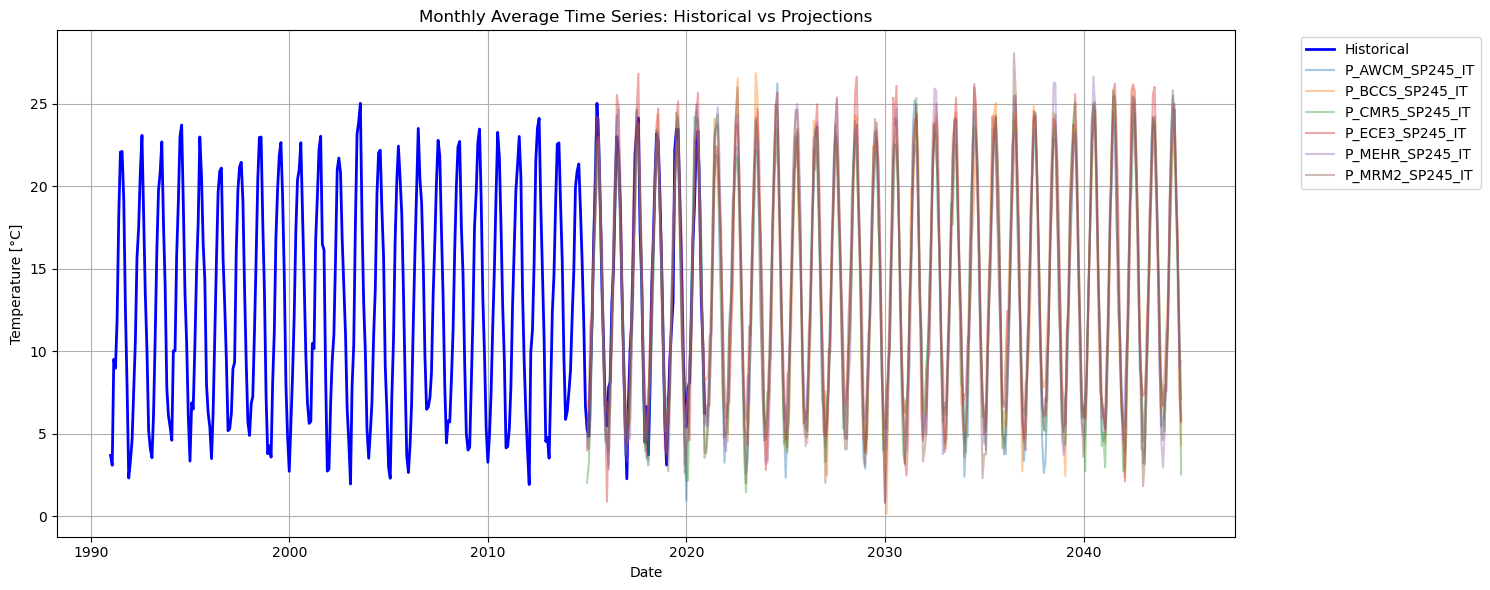

In [11]:
# For simplicity we can separately define the historical and projection columns of the df
df_hist = df.loc[:, df.columns.str.startswith('H')]
df_proj = df.loc[:, df.columns.str.startswith('P')]

plt.figure(figsize=(15, 6))

# Plot historical line (blue)
plt.plot(df_hist.index, df_hist, label="Historical", color="blue", linewidth=2)
# Plot all projections (gray lines with alpha for transparency)
for col in df_proj.columns:
    plt.plot(df_proj.index, df_proj[col], label=col, alpha=0.4)

# Highlight plot settings
plt.title("Monthly Average Time Series: Historical vs Projections")
plt.xlabel("Date")
plt.ylabel(f"Temperature [{units}]")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
plt.show()

The plot we see isn’t particularly informative, right?
We can see the projected temperatures appear to be higher on average, but we can't really distinguish between a model and the other.

Let's zoom on a particular year, by simply limiting the x-axis for instance:

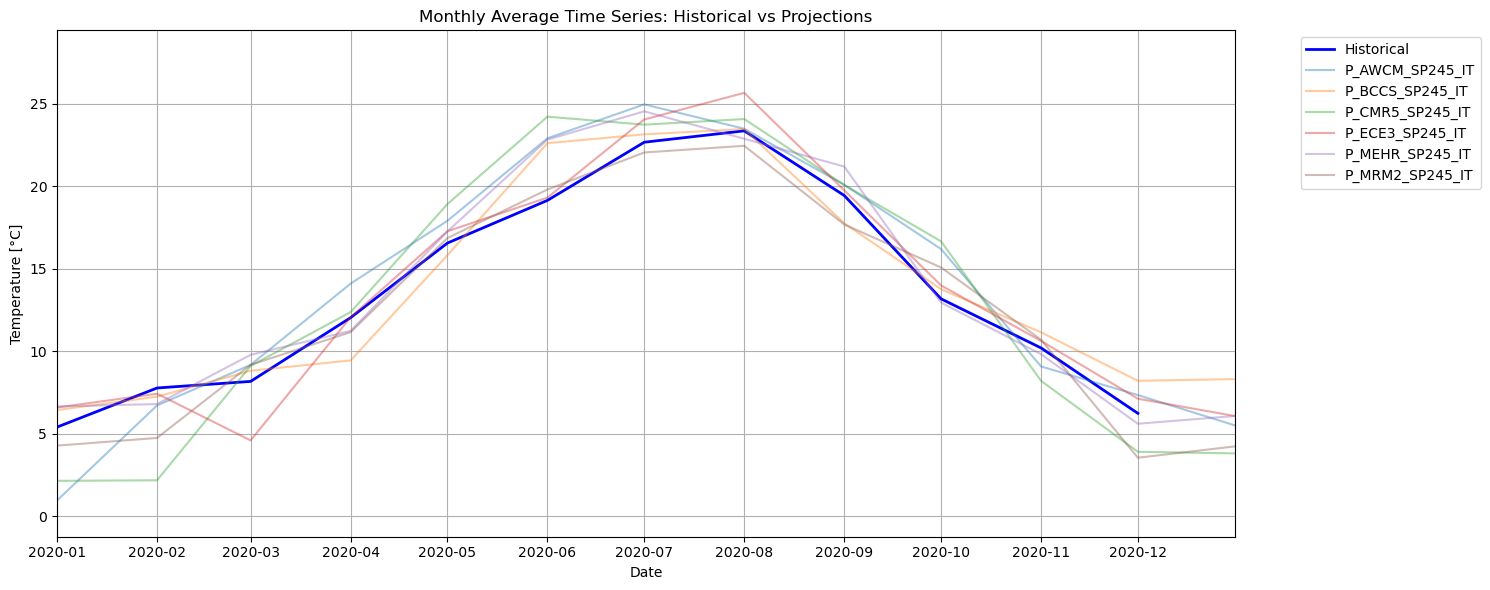

In [12]:
# Selecting year
year_x = 2020

# Here we are repeating the previous code, just adding one line
plt.figure(figsize=(15, 6))

# Plot historical line (blue)
plt.plot(df_hist.index, df_hist, label="Historical", color="blue", linewidth=2)
# Plot all projections (gray lines with alpha for transparency)
for col in df_proj.columns:
    plt.plot(df_proj.index, df_proj[col], label=col, alpha=0.4)

# Highlight plot settings
plt.title("Monthly Average Time Series: Historical vs Projections")
plt.xlabel("Date")
plt.ylabel(f"Temperature [{units}]")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.xlim(pd.to_datetime(f"{year_x}-01-01"), pd.to_datetime(f"{year_x}-12-31"))  # <-- NEW LINE
plt.tight_layout()
plt.show()

Here we can better compare the ensemble of models under this specific scenario with the reanalysis. However, all these overlapping lines make the plot hard to interpret. Also: which of these lines (which model) should I trust?
Let’s try to see it from another perspective: let's create an envelope of the projections to see within what range they fall.

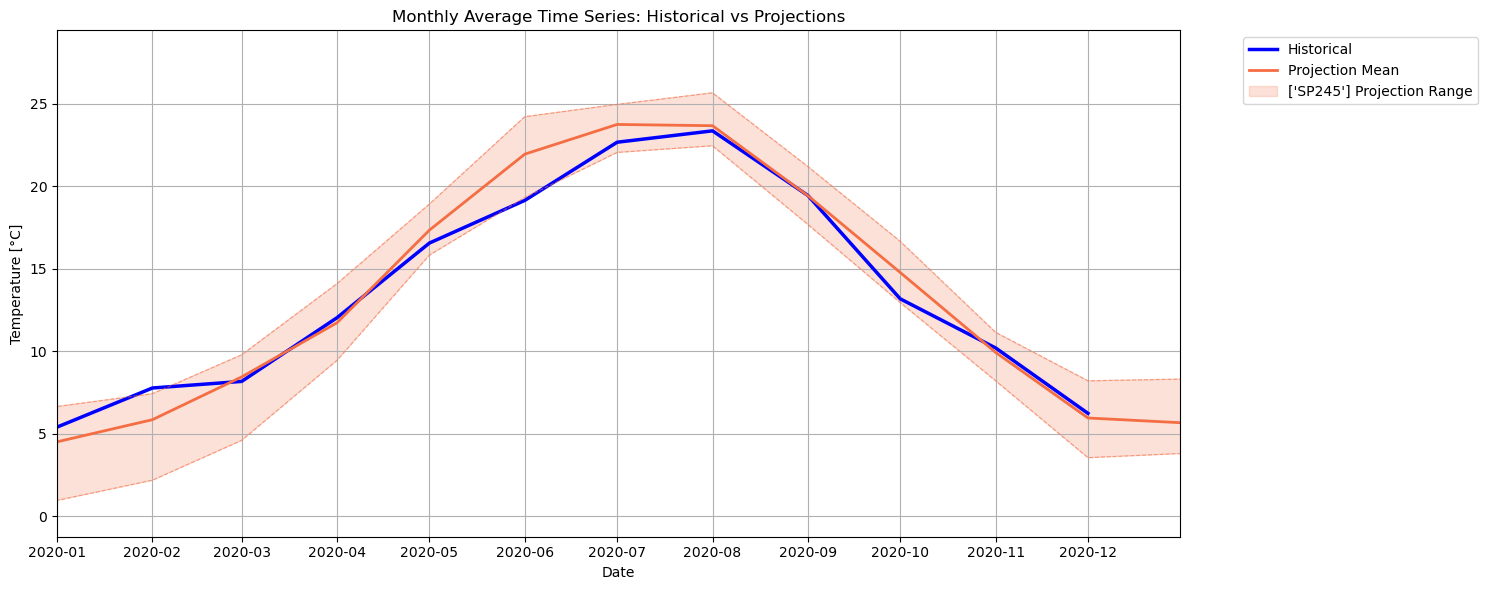

In [13]:
# Calculate the average, min, and max across all projection columns for 2015
proj_mean = df_proj.mean(axis=1)
proj_min = df_proj.min(axis=1)
proj_max = df_proj.max(axis=1)

# Plotting
plt.figure(figsize=(15, 6))

# SSP color
ssp_color = '#f46d43'

# 1. Plot historical data (thick blue line)
plt.plot(df_hist.index, df_hist, label="Historical", color="blue", linewidth=2.5)

# 2. Plot mean of projections (thick red line)
plt.plot(df_proj.index, proj_mean, label="Projection Mean", color=ssp_color, linewidth=2)

# 3. Fill between min and max (shaded red envelope)
p_label = f"{p_scenarios} Projection Range"
plt.fill_between(
    df_proj.index, proj_min, proj_max, color=ssp_color, alpha=0.2, label=p_label
)

# 4. Outline the min and max envelope (thin red dashed lines)
plt.plot(df_proj.index, proj_min, color=ssp_color, linewidth=0.8, linestyle="--", alpha=0.6)
plt.plot(df_proj.index, proj_max, color=ssp_color, linewidth=0.8, linestyle="--", alpha=0.6)

# Final formatting
plt.title("Monthly Average Time Series: Historical vs Projections")
plt.xlabel("Date")
plt.ylabel(f"Temperature [{units}]")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlim(pd.to_datetime(f"{year_x}-01-01"), pd.to_datetime(f"{year_x}-12-31"))
plt.tight_layout()
plt.show()

The projections are now shown with their ensemble mean (solid line) plus the ensemble spread (shaded band between min and max dashed lines). This provides a view on the average temperature across all these climate models, as well as an indication of their overall uncertainty (high or low, depending on the thickness of the band). Here we see that the temperature from the reanalysis generally falls within the uncertainty range of these ensemble: this can be seen also for other past years. We can now look at future temperature in these new terms.

## Future vs. Past Temperature

Let's now go back to the first figure to try and extract some useful information about future temperatures. For instance, we can compute yearly averages of the data, and re-arrange it, as done earlier, in terms of ensemble mean and spread:

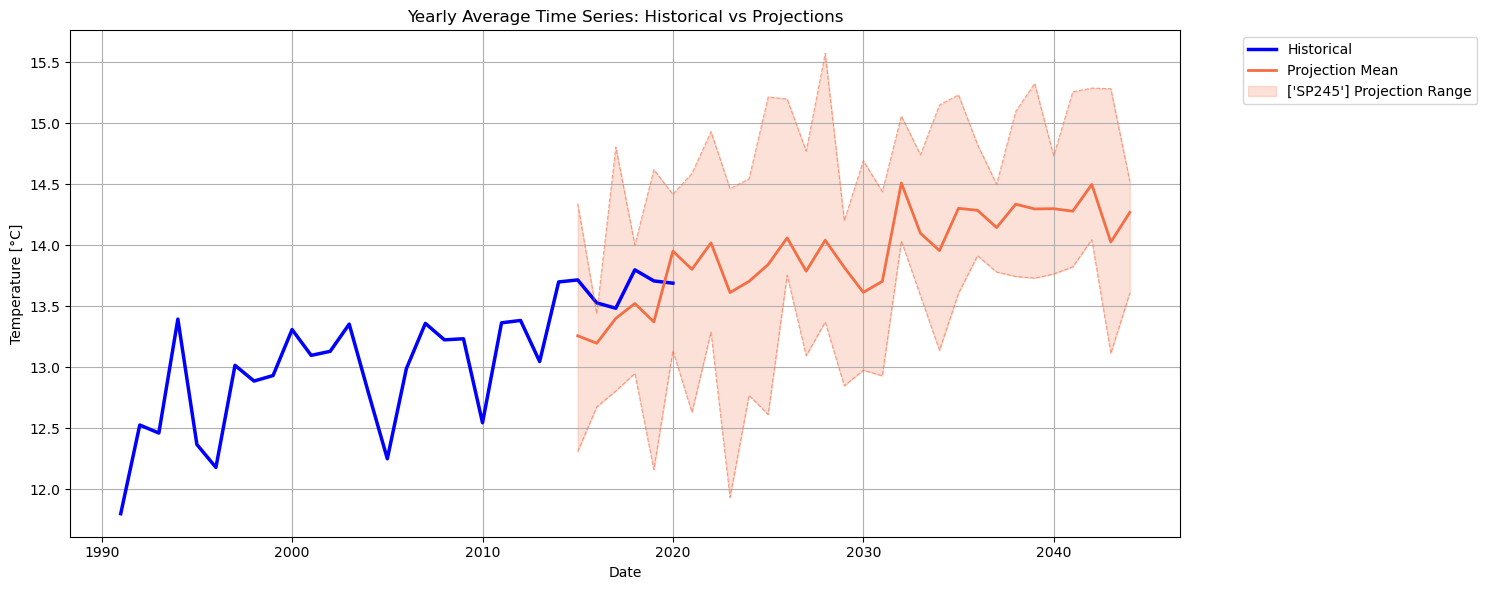

In [24]:
# Resample yearly and average
hist_yearly = df_hist.resample("YS").mean()
proj_yearly = df_proj.resample("YS").mean()

# Calculate the average, min, and max across all projection columns for 2015
proj_mean_y = proj_yearly.mean(axis=1)
proj_min_y = proj_yearly.min(axis=1)
proj_max_y = proj_yearly.max(axis=1)

# Plotting
plt.figure(figsize=(15, 6))

# SSP color
ssp_color = '#f46d43'

# 1. Plot historical data (thick blue line)
plt.plot(hist_yearly.index, hist_yearly, label="Historical", color="blue", linewidth=2.5)

# 2. Plot mean of projections (thick red line)
plt.plot(proj_mean_y.index, proj_mean_y, label="Projection Mean", color=ssp_color, linewidth=2)

# 3. Fill between min and max (shaded red envelope)
p_label = f"{p_scenarios} Projection Range"
plt.fill_between(
    proj_yearly.index, proj_min_y, proj_max_y, color=ssp_color, alpha=0.2, label=p_label
)

# 4. Outline the min and max envelope (thin red dashed lines)
plt.plot(proj_yearly.index, proj_min_y, color=ssp_color, linewidth=0.8, linestyle="--", alpha=0.6)
plt.plot(proj_yearly.index, proj_max_y, color=ssp_color, linewidth=0.8, linestyle="--", alpha=0.6)

# Final formatting
plt.title("Yearly Average Time Series: Historical vs Projections")
plt.xlabel("Date")
plt.ylabel(f"Temperature [{units}]")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Also in this figure, we can see how the historical temperatures for the overlapping period generally fall within this SSP ensemble range; however, we must keep in mind that the CMIP6 models are constrained by specific socio-economic assumptions (that vary for each emission scenario): the CMIP6 models are not reanalysis models and some differences with respect to ERA5 are to be expected. The projected temperature trend is now pretty evident under this particular scenario. To understand how other scenarios project temperature, the corresponding data can be downloaded and added here to plot them all together in the same figure.

## Take home messages 📌

*   PECDv4.2 climate and energy data for both historical record and future climate projections can be easily downloaded from the CDS, processed, and visualized.
*   Resampling to a lower temporal resolution can be useful to better visualize and compare data spanning a long time window.
*   Basic statistics (e.g., mean, standard deviation) can be computed using simple operations and are useful to extract key information from the large quantity of available data.
*   Estimates of climate change projected trends can be done pretty quickly, especially with aggregated data (CSV files) or specific locations' series extracted from gridded data (netCDF files).